# Code to create dataset 
### Create dataset for training and testing neural network

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from sklearn import gaussian_process
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle
from scipy import interpolate

In [3]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ygr = lorentzian_components(params_gr, t*3600*24)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(t)
  
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc= 3, scale = 0.3, size=len(t)) # m/s
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    return ytot, eb

    
def generate_planete(t, params_pl):
    Ppl,K,T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)




def generate_data(t,dt,Ttot,freq,params_gr,nbr_planete):
    
    Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot) 
    gam  = 2.0/epsilon #not change
    logP = np.log(Prot) #not change 
    met  = 1 # not change 

    params_act = [amp, gam, logP, met]
    
    y, eb = generate_regular_data_H0(params_gr, params_act, t)
    
    if ( nbr_planete == 0):
        ls = LombScargle(t,y,eb).power(freq,method='cython')
        maxs = [freq[np.argmax(ls)], max(ls)]
        label = 0
        freq_pl = 0
        
    else:
        freq_pl = np.zeros(nbr_planete)
        for i in range(nbr_planete):
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            freq_pl[i] = 1/Ppl
            y += generate_planete(t,(Ppl,K,T0))
        
        ls = LombScargle(t,y,eb).power(freq,method='cython')
        maxs = [freq[np.argmax(ls)], max(ls)]
        
        if (any(np.isclose(freq_pl, maxs[0], atol=0.002))):
            label = 1
        else:
            label = 0
        
    return ls, maxs, label, params_act
    

# Test function

In [4]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days

# Irregular sampling 1 : with normal distribution
facteur_ech = 10
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ] 

ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1]  = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-1):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i] = t_over[ ind ]

    
dt = np.median(np.diff(t))
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)

Maxs : [0.03455820870623132, 0.30453418773310675]
label : 1


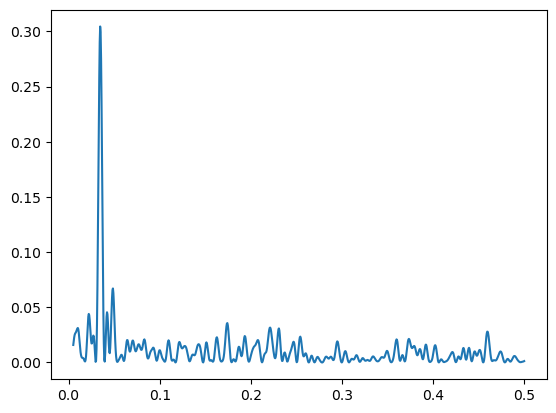

In [5]:
#Simu
A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz


params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq, params_gr,1)
print("Maxs :", maxs)
print("label :",label)
plt.plot(freq,ls)

proportion label negatif =  1.0


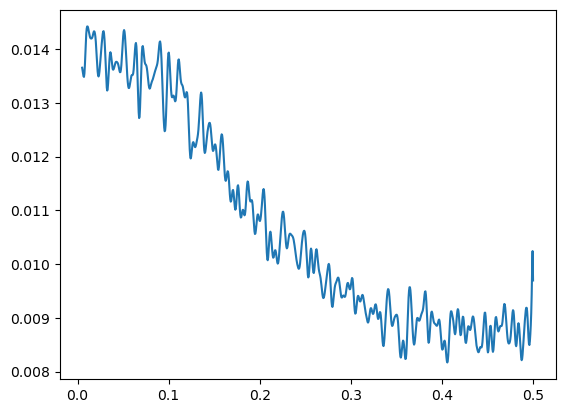

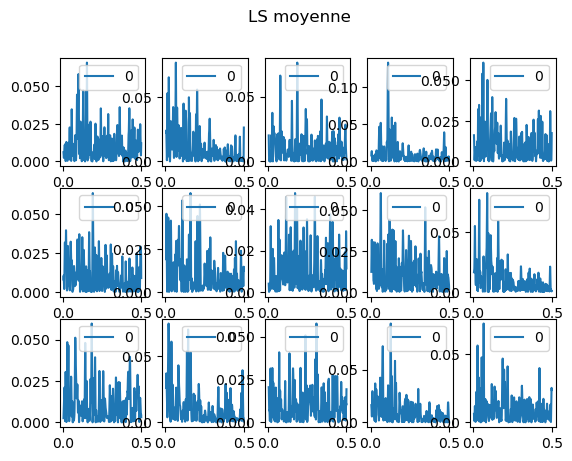

In [6]:
planete = 0

LS = []
Maxs = []
Label = []


#Simu

A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6# m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

N = 1000
for i in range(N):
    ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq, params_gr,planete)
    LS.append(ls)
    Maxs.append(maxs)
    Label.append(label)
    
print("proportion label negatif = ",(Label.count(0)/N) )


lsmoy = np.mean(LS, axis = 0)

#plot mean LS
plt.figure()
plt.plot(freq,lsmoy)

plt.figure()
plt.suptitle("LS moyenne")
k = 1
for i in range(3):
    for j in range(5):
        ind = random.randint(0,(N-1))
        plt.subplot(3,5,k), plt.plot(freq, LS[ind],label = Label[ind]), plt.legend()
        k+=1

# Create dataset

In [7]:
#Data set 1 => 50% positif / 50% negatif

def create_dataset1(nb_periodogramme, pourcentage_positif, t, dt, Ttot, f):
    
    nb_par_cas = np.zeros(5)
    nb_ech = nb_periodogramme/5
    count_label_neg = 0
    count_label_pos = 0
    nb_cas_pos = pourcentage_positif * nb_periodogramme
    start = time.time()
    
    LS = []
    Maxs = []
    Labels = []
    
       
    #Simu
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Generate negatif label
    #Generate H0 data
    print("Generation de label negatif :")
    print(nb_par_cas)
    while(nb_par_cas[0]<nb_ech):
        ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq,params_gr,0)
        LS.append(ls)
        Maxs.append(maxs)
        Labels.append(label)
        count_label_neg +=1
        nb_par_cas[0]+=1
    print(nb_par_cas)
    
    nb_with_planete_negatif_label = ((1-pourcentage_positif)*nb_periodogramme - nb_ech)/4
    
    for i in range(1,5):
        #Generate data with i planet
        while(nb_par_cas[i]<nb_with_planete_negatif_label):
            ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq,params_gr,i)
            if (label == 0 ):
                LS.append(ls)
                Maxs.append(maxs)
                Labels.append(label)
                count_label_neg +=1
                nb_par_cas[i]+=1
        print(nb_par_cas)
    
    print("Repartition negatif label =", nb_par_cas)
    
    
    
    #Generate positif label
    print("Generation de label positif :")
    print(nb_par_cas)
    for i in range(1,5):
        #Generate data with i planet
        while(nb_par_cas[i]<nb_ech):
            ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq,params_gr,i)
            if (label == 1 ):
                LS.append(ls)
                Maxs.append(maxs)
                Labels.append(label)
                count_label_neg +=1
                nb_par_cas[i]+=1
        print(nb_par_cas)
    
    
    print("\nNbr totale d'ech = ", len(LS))
    print("Temps d'execution total = ", time.time()-start, "s")
    print("Pourcentage label positif = ", Labels.count(1)/len(Labels))
    print("Pourcentage label negatif = ", Labels.count(0)/len(Labels))
    
    return LS, Maxs, Labels

In [8]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days

# Irregular sampling 1 : with normal distribution
facteur_ech = 10
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ] 

ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1]  = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-1):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i] = t_over[ ind ]

    
dt = np.median(np.diff(t))
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)

In [13]:
LS, Maxs, Labels = create_dataset1(13700,0.5,t,dt,Ttot,freq)

Generation de label negatif :
[0. 0. 0. 0. 0.]
[2740.    0.    0.    0.    0.]
[2740. 1028.    0.    0.    0.]
[2740. 1028. 1028.    0.    0.]
[2740. 1028. 1028. 1028.    0.]
[2740. 1028. 1028. 1028. 1028.]
Repartition negatif label = [2740. 1028. 1028. 1028. 1028.]
Generation de label positif :
[2740. 1028. 1028. 1028. 1028.]
[2740. 2740. 1028. 1028. 1028.]
[2740. 2740. 2740. 1028. 1028.]
[2740. 2740. 2740. 2740. 1028.]
[2740. 2740. 2740. 2740. 2740.]

Nbr totale d'ech =  13700
Temps d'execution total =  734.8551647663116 s
Pourcentage label positif =  0.4998540145985401
Pourcentage label negatif =  0.5001459854014598


In [42]:
#Save dataset 1
import pickle

def full_pickle(title, data):
 pikd = open(title + '.pickle', 'wb')
 pickle.dump(data, pikd)
 pikd.close()

def loosen(file):
 pikd = open(file, 'rb')
 data = pickle.load(pikd)
 pikd.close()
 return data

In [ ]:
full_pickle("./data/set1/LS",LS)
full_pickle("./data/set1/Maxs",Maxs)
full_pickle('./data/set1/Labels',Labels)
full_pickle('./data/set1/Freq', freq)

In [16]:
#Data set 2/3

def create_dataset(nb_periodogramme, t, dt, Ttot, f):
    
    nb_par_cas = np.zeros(5)
    nb_ech = nb_periodogramme/5
    start = time.time()
    
    LS = []
    Maxs = []
    Labels = []
    Params_act = []
    
       
    #Simu
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Generate H0 data
    print(nb_par_cas)
    while(nb_par_cas[0]<nb_ech):
        ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq,params_gr,0)
        LS.append(ls)
        Maxs.append(maxs)
        Labels.append(label)
        Params_act.append(params_act)
        nb_par_cas[0]+=1
    print(nb_par_cas)
    
    
    for i in range(1,5):
        #Generate data with i planet
        while(nb_par_cas[i]<nb_ech):
            ls, maxs, label, params_act = generate_data(t,dt,Ttot,freq,params_gr,i)
            LS.append(ls)
            Maxs.append(maxs)
            Labels.append(label)
            Params_act.append(params_act)
            nb_par_cas[i]+=1
        print(nb_par_cas)
  
    
    
    print("\nNbr totale d'ech = ", len(LS))
    print("Temps d'execution total = ", time.time()-start, "s")
    print("Pourcentage label positif = ", Labels.count(1)/len(Labels))
    print("Pourcentage label negatif = ", Labels.count(0)/len(Labels))
    
    return LS, Maxs, Labels, Params_act

In [17]:
LS_test, Maxs_test, Labels_test, Params_act = create_dataset(10000, t, dt, Ttot, freq)

[0. 0. 0. 0. 0.]
[2000.    0.    0.    0.    0.]
[2000. 2000.    0.    0.    0.]
[2000. 2000. 2000.    0.    0.]
[2000. 2000. 2000. 2000.    0.]
[2000. 2000. 2000. 2000. 2000.]

Nbr totale d'ech =  10000
Temps d'execution total =  341.3211326599121 s
Pourcentage label positif =  0.5566
Pourcentage label negatif =  0.4434


In [18]:
full_pickle("./data/set2/LS_test",LS_test)
full_pickle("./data/set2/Maxs_test",Maxs_test)
full_pickle('./data/set2/Labels_test',Labels_test)
full_pickle('./data/set2/Freq_test', freq)
full_pickle('./data/set2/Params_act',Params_act)

### Built ddp for FAP method

In [16]:
def create_pdf(t,freq,N):
    amps = np.zeros(N)
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = random.randint(10,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)
        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1 # not change 
        params_act = [amp, gam, logP, met]
        
        y,eb = generate_regular_data_H0(params_gr, params_act,t)
        ls = LombScargle(t,y,eb).power(freq,method='cython')
        amps[i] = max(ls)
        
    pdf = np.histogram(amps, bins = 50, density = True)
    # plt.bar(hist[1][:-1], hist[0], width=np.diff(hist[1]), align='edge') to plot
    return pdf # y,x

In [17]:
pdf_mean = create_pdf(t,freq,10000)

Temps : 230.19131684303284


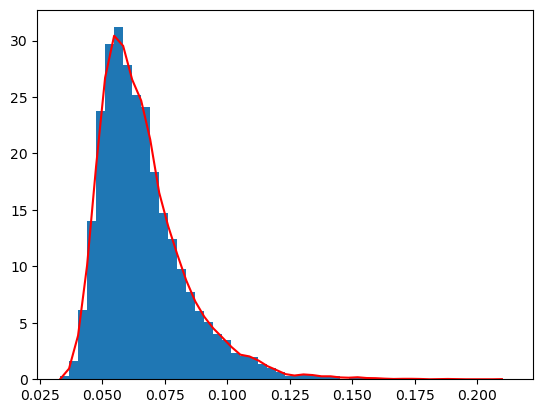

In [18]:
mean_bin = np.zeros(pdf_mean[1].shape[0]-1)
for i in range(pdf_mean[1].shape[0]-1) : mean_bin[i] = (pdf_mean[1][i+1] + pdf_mean[1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdf_mean[0],bounds_error = False, fill_value = (0,0))

plt.bar(pdf_mean[1][:-1], pdf_mean[0], width=np.diff(pdf_mean[1]), align='edge')
plt.plot(pdf_mean[1][:-1], f_pdf(pdf_mean[1][:-1]), c ='r')

In [26]:
full_pickle('./data/set2/pdf_mean',pdf_mean)

### Build distributions for each frequency

In [26]:
def create_pdf_each_freq(t,freq,N):
    LS = np.zeros((freq.shape[0],N))
    pdfs = []
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = random.randint(10,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)
        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1 # not change 
        params_act = [amp, gam, logP, met]
        
        y,eb = generate_regular_data_H0(params_gr, params_act,t)
        ls = LombScargle(t,y,eb).power(freq,method='cython')
        LS[:,i] = ls
    
    for k in range(freq.shape[0]):
        pdfs.append( np.histogram(LS[k,:], bins = 50, density = True) )
        
    # plt.bar(hist[1][:-1], hist[0], width=np.diff(hist[1]), align='edge') to plot
    return pdfs # y,x

In [33]:
pdfs = create_pdf_each_freq(t,freq,10000)

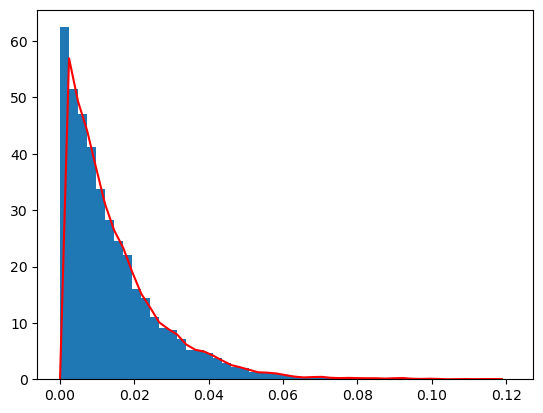

In [39]:
ind = 100
mean_bin = np.zeros(pdfs[ind][1].shape[0]-1)
for i in range(pdfs[ind][1].shape[0]-1) : mean_bin[i] = (pdfs[ind][1][i+1] + pdfs[ind][1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdfs[ind][0],bounds_error = False, fill_value = (0,0))
plt.bar(pdfs[ind][1][:-1], pdfs[ind][0], width=np.diff(pdfs[ind][1]), align='edge')
plt.plot(pdfs[ind][1][:-1], f_pdf(pdfs[ind][1][:-1]), c ='r')

In [43]:
full_pickle('./data/set2/pdfs',pdfs)